This notebook is Jett's quick attempt to reproduce the results of [this work](https://www.lesswrong.com/posts/gTZ2SxesbHckJ3CkF/transformers-represent-belief-state-geometry-in-their)

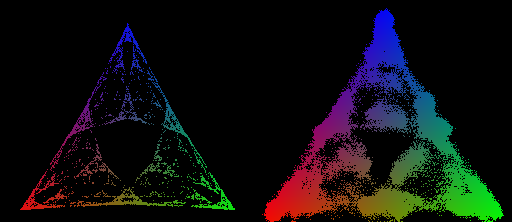

GPU is preferred, but this should work without it. Training is optional, it will load a pre-trained model by default.

## setup

In [30]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import PIL.Image
from transformers import LlamaConfig, LlamaForCausalLM
from sklearn.linear_model import LinearRegression

In [31]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"{device=}")
SEED = 23
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device='mps'


## defining mess3 process

In [ ]:
def get_mess3_t(x, alpha):
    beta = (1 - alpha) / 2
    y = 1 - 2 * x

    T_A = torch.tensor([
        [alpha * y, beta * x, beta * x],
        [alpha * x, beta * y, beta * x],
        [alpha * x, beta * x, beta * y]
    ], dtype=torch.float, device=device)

    T_B = torch.tensor([
        [beta * y, alpha * x, beta * x],
        [beta * x, alpha * y, beta * x],
        [beta * x, alpha * x, beta * y]
    ], dtype=torch.float, device=device)

    T_C = torch.tensor([
        [beta * y, beta * x, alpha * x],
        [beta * x, beta * y, alpha * x],
        [beta * x, beta * x, alpha * y]
    ], dtype=torch.float, device=device)

    return torch.stack([T_A, T_B, T_C])

In [33]:
T = get_mess3_t(x=0.05, alpha=0.85)
trans = T.permute(2, 1, 0)  # TODO: use T everywhere
vocab_size, n_states, _ = T.shape
prior = torch.ones(n_states, dtype=torch.float, device=device) / n_states

## generation & beliefs updates

In [34]:
def generate(num_sequences, length):
    tokens = torch.zeros(num_sequences, length, dtype=torch.int64, device=device)
    state = torch.multinomial(prior, num_sequences, replacement=True)
    for i in range(length):
        # probabilities of transitioning to each (state, token) pair
        # indexed as state_idx * vocab_size + token_idx
        pairs_trans = trans[state].reshape(num_sequences, -1)
        pairs = torch.multinomial(pairs_trans, 1, replacement=True).squeeze()
        state = pairs // vocab_size
        tokens[:, i] = pairs % vocab_size
    return tokens

In [35]:
def compute_beliefs(tokens):
    num_sequences, length = tokens.shape
    beliefs = torch.zeros(num_sequences, length + 1, n_states, dtype=torch.float, device=device)
    beliefs[:, 0] = prior
    for i in range(length):
        # unnormalized
        trans_mat = trans[..., tokens[:, i]].permute(2, 1, 0)
        beliefs[:, i+1] = (trans_mat @ beliefs[:, i, :, None]).squeeze()
        beliefs[:, i+1] = beliefs[:, i+1] / beliefs[:, i+1].sum(-1, keepdim=True)
    return beliefs

## model training

In [36]:
TRAIN = False
D_MODEL = 64
BATCH_SIZE = 32
N_STEPS = 2000
N_CTX = 100
VAL_SIZE = 1000
LOG_EVERY_STEPS = 100
config = LlamaConfig(
    hidden_size=D_MODEL,
    intermediate_size=D_MODEL * 8 // 3,
    num_attention_heads=4,
    num_key_value_heads=4,
    vocab_size=vocab_size
)
if TRAIN:
    model = LlamaForCausalLM(config).to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    best_model_state_dict = model.state_dict()
    best_val_loss = float("inf")
    val_tokens = generate(VAL_SIZE, N_CTX)
    for step in range(N_STEPS):
        tokens = generate(BATCH_SIZE, N_CTX)
        loss = model(tokens, labels=tokens, return_dict=True).loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        if step % LOG_EVERY_STEPS == 0:
            with torch.no_grad():
                val_loss = model(val_tokens, labels=val_tokens, return_dict=True).loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state_dict = model.state_dict()
                print(f"train {loss.item():.4f} val {val_loss.item():.4f} best val {best_val_loss.item():.4f}")
    best_model = LlamaForCausalLM(config)
    best_model.load_state_dict(best_model_state_dict)
    best_model.to(device)
else:
    best_model = LlamaForCausalLM.from_pretrained("jettjaniak/mess3-llama-17-05-2024").to(device)

## probe training

In [37]:
best_model.eval()

def tokens_to_probe_inputs(tokens):
    with torch.no_grad():
        activation: torch.tensor = None
        def hook(model, input, output):
            nonlocal activation
            activation = output[0]
        hook_handle = best_model.model.layers[-1].register_forward_hook(hook)
        best_model(tokens)
        hook_handle.remove()
        return activation.reshape(-1, activation.shape[-1])

def tokens_to_probe_targets(tokens):
    beliefs = compute_beliefs(tokens)[:, 1:]
    return beliefs[..., :n_states-1].reshape(-1, n_states-1)

In [38]:
def train_probe(n_samples):
    tokens = generate(n_samples, N_CTX)
    probe_inputs = tokens_to_probe_inputs(tokens).cpu()
    probe_targets = tokens_to_probe_targets(tokens).cpu()
    return LinearRegression().fit(probe_inputs, probe_targets)
probe = train_probe(n_samples=1_000)

RuntimeError: multinomial only supports floating-point dtypes for input, got: Int

## overcomplicated plotting

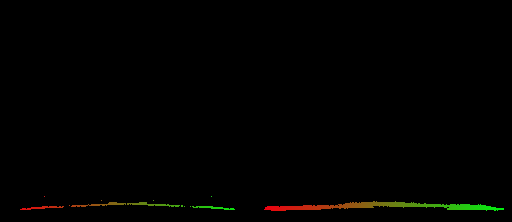

In [ ]:
def get_unique_a_b(a, b):
    a = (a * 255).to(torch.int)
    b = (b * 255).to(torch.int)
    sum = a + b
    mask_a = (a >= 0) & (a <= 255)
    mask_b = (b >= 0) & (b <= 255)
    mask_sum = (sum >= 0) & (sum <= 255)
    mask = mask_a & mask_b & mask_sum
    pairs = torch.stack([a[mask], b[mask]], dim=1)
    try:
        return torch.unique(pairs, dim=0)
    except NotImplementedError:
        return torch.unique(pairs.cpu(), dim=0).to(device)

def create_image(N, x, y, c):
    # Initialize an empty image
    image = np.zeros((N, N, 3), dtype=np.uint8)

    # Convert normalized coordinates to pixel indices
    x_indices = (x * (N - 1)).astype(int)
    y_indices = (y * (N - 1)).astype(int)

    # Assign colors to the image based on the coordinates
    for i in range(len(x)):
        image[y_indices[i], x_indices[i]] = c[i]

    return image

def display_image(image):
    # Convert the numpy array to a PIL image
    pil_image = PIL.Image.fromarray(image)

    # Display the image
    display(pil_image)

def update_image(image, a, b):
    c = 255 - a - b
    y = (2 * b + c) // 2
    x = ((3 ** 0.5) * c).to(torch.int) // 2
    colors = torch.stack([a, b, 255 - a - b], dim=1)
    image[x, y] = colors.to(torch.uint8)

def plot(n_batches, batch_size):
    max_height = int(3 ** 0.5 * 128) + 1
    targets_image = torch.zeros((max_height, 256, 3), dtype=torch.uint8, device=device)
    outputs_image = torch.zeros_like(targets_image)
    for _ in range(n_batches):
        tokens = generate(batch_size, N_CTX)
        probe_inputs = tokens_to_probe_inputs(tokens)
        probe_targets = tokens_to_probe_targets(tokens)
        probe_outputs = torch.tensor(probe.predict(probe_inputs.cpu()), device=device)
        update_image(targets_image, *get_unique_a_b(*probe_targets.T).T)
        update_image(outputs_image, *get_unique_a_b(*probe_outputs.T).T)

    joint_image = torch.cat([targets_image, outputs_image], dim=1).cpu().numpy()
    display(PIL.Image.fromarray(joint_image[::-1]))

plot(n_batches=6 if device == "cuda" else 2, batch_size=1_000)

Not as close to the ground truth as I hoped. When I looked at mess3 with different parameters it was hard to get the transformer to converge to optimal solution. I didn't check in this case, but I expect this is what's going on.